In [3]:
import pandas as pd
import numpy as np
import geopandas as gp
import fiona
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
from matplotlib import pyplot
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import json
import datetime
import pickle
from ipypb import track
from ipypb import chain
import seaborn as sn
import glob
from fastkml import kml

os.chdir("E:/University College London/O'Sullivan, Aidan - SDG6")

### Swedish lakes

In [16]:
sel = gp.read_file('./Shapefiles/Sweden/levande-sjoar-vattendrag-20160622/levande-sjoar-vattendrag.shp')

In [17]:
sel['omradestyp'] = ['Other' if i is None else i for i in sel.omradestyp ]

In [18]:
sel['omradestyp'].unique()

array(['Vattendrag', 'Vattensystem', 'Sjö', 'Del av vattendrag', 'sjö',
       'Del av Sjö', 'del av sjö', 'vattendrag', 'Other',
       'del av vattendrag', 'vattensystem', 'småvatten', 'sjöar',
       'Öreälven'], dtype=object)

In [27]:
sel_lakes = sel[['sjö' in i for i in sel.omradestyp]]
sel_lakes = sel_lakes.append(sel[['Other' in i for i in sel.omradestyp]])
sel_lakes = sel_lakes.append(sel[['Sjö' in i for i in sel.omradestyp]])

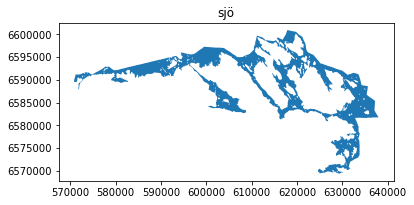

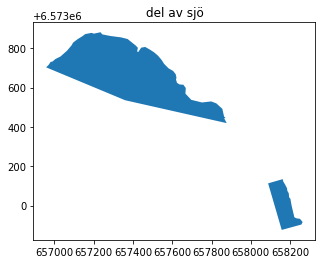

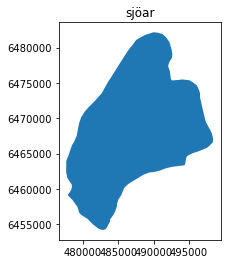

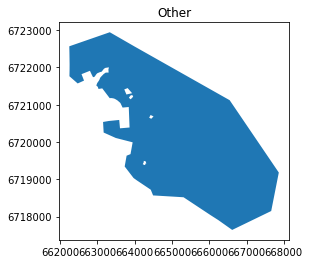

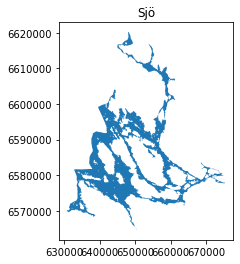

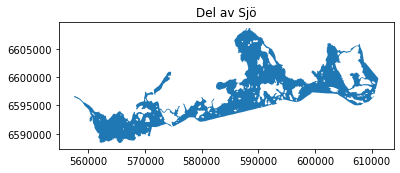

In [28]:
types = sel_lakes.omradestyp.unique()

for typesi in types:
    sel_lakes[[typesi in i for i in sel_lakes.omradestyp]][0:1].plot()
    plt.title(typesi)

In [37]:
sel = sel[sel.geometry.type=='Polygon']
sel[['VATTNAMN','HAROnamnAu','OmrID','geometry']].to_file('.\Shapefiles\Sweden\sweden_wb.shp')

### Lithuania

In [63]:
litv = gp.read_file('./Shapefiles/Lithuania/lithuania_lakes.shp')

In [14]:
litv = litv[litv.geometry.type=='Polygon']
litv[['id','name:en','geometry']].to_file('lithuania_lakes.shp')

### Northern Ireland

In [36]:
nil = gp.read_file('./Shapefiles/UK/ni.geojson')
nil.geometry.type.unique()

In [38]:
nil = nil[nil.geometry.type!='LineString']
nil[['id','name:en','geometry']].to_file('ni_lakes.shp')

In [51]:
nil2 = gp.read_file('./Shapefiles/UK/SurfaceWaterBodiesWith2015status.gml')

In [55]:
nil2 = nil2[nil2.spZoneType=='lakeWaterBody']

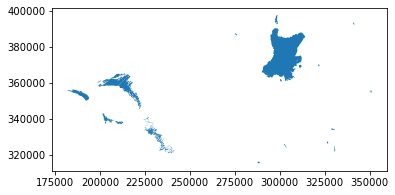

In [56]:
nil2.plot()

In [61]:
nil2.to_file('ni_lakes2.shp')

### France

In [70]:
all_files = glob.glob('./Shapefiles/France/export*')

li = []

for filename in all_files:
    gdf = gp.read_file(filename)
    li.append(gdf)

frwb = pd.concat(li, axis=0, ignore_index=True)

## Keep only relevant geometries

frwb = frwb[['id','name:fr','geometry']]
frwb = frwb[frwb.geometry.type!='LineString']
frwb = frwb[frwb.geometry.type!='Point']
frwb.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [43]:
sites2 = pd.read_pickle(r"C:/Users/User/Documents/Work/SDGs and AI/6.3.2/sites2.p")

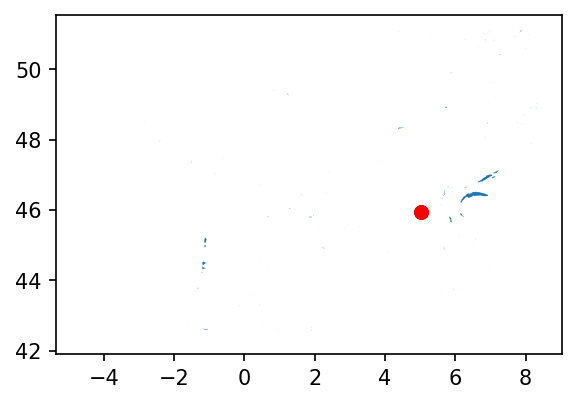

In [71]:
### checking missing geomerty locations

trysites = sites2[['FR' in i for i in sites2.index.get_level_values(0)]].set_geometry('geometry_ll').reset_index()

## country outlines
ct = gp.read_file('.//Shapefiles//Country boundaries//CNTR_RG_60M_2016_4326.shp')
ct = ct.to_crs(sites2.crs)

minx, miny, maxx, maxy = trysites.geometry.total_bounds

fig, ax = plt.subplots(dpi=150, figsize =(5, 3))


#ct.plot(ax=ax)
trysites[trysites.geometry_poly.isna()].plot(color='r',ax=ax)
frwb.to_crs(trysites.crs).plot(ax=ax)

#ax.set_xlim(minx, maxx) 
#ax.set_ylim(miny, maxy)

In [77]:
m = Map(center=(55.8064, 25.3829), zoom = 9, basemap= basemaps.Esri.WorldTopoMap)


ukwb_tp = GeoData(geo_dataframe = frwb.to_crs(trysites.crs),
                   style={'color': 'black', 'fillColor': '#1e7a65', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'EA wb')

sites = GeoData(geo_dataframe = trysites.loc[trysites.geometry_poly.isna(),['sid','geometry_ll']],
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'EEA Lakes')

m.add_layer(ukwb_tp)
#m.add_layer(sites_buff)
m.add_layer(sites)
m.add_control(LayersControl())

m

Map(center=[55.8064, 25.3829], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### WWF Global Lakes Database

In [30]:
glwd = gp.read_file('.\Shapefiles\glwd_2.shp')

In [31]:
glwd = gp.GeoDataFrame(geometry=glwd.geometry,crs=sites.crs)

In [32]:
glwd.crs

In [33]:
glwd.head()

,geometry
0,"POLYGON ((91.00000 68.95627, 91.01169 68.96088..."
1,"POLYGON ((-56.08964 48.20517, -56.06390 48.216..."
2,"POLYGON ((89.84557 30.91323, 89.83953 30.91154..."
3,"POLYGON ((-84.53149 30.48898, -84.53565 30.467..."
4,"POLYGON ((-71.48501 10.94863, -71.48820 10.952..."


In [62]:
sites_un = sites.geometry.unary_union
site_un = sites_un.to_crs(glwd.crs)

glwd_clip = glwd[glwd.geometry.intersects(sites_un)]

AttributeError: 'MultiPoint' object has no attribute 'to_crs'

### USA

In [47]:
uswb_l = uswb

265911

In [50]:
uswb = gp.read_file('./Waterbody shapefiles/US/rad_impw02_20140207_shp/rad_impw02_20140207/rad_impw02_a.shp')
print(list(uswb))
print(uswb.geometry.type.unique())
print(len(uswb))
uswb.head(2)


['PERMID', 'EVENTDATE', 'REACHCODE', 'RCHSMDATE', 'RCHRESOLUT', 'FEATPERMID', 'FEATCLSRF', 'SOURCE_ORG', 'SRCE_DESCR', 'SRC_FEATID', 'DETAILURL', 'EVENTTYPE', 'EAREA_SQKM', 'GEOGSTATE', 'CYCLE_YEAR', 'START_DATE', 'END_DATE', 'HUC12', 'HUC12_PERC', 'NHDRCH_CAC', 'VERTICES', 'SHAPE_AREA', 'SHAPE_LEN', 'ESRI_KEY', 'geometry']
['Polygon' 'MultiPolygon']
14445


,PERMID,EVENTDATE,REACHCODE,RCHSMDATE,RCHRESOLUT,FEATPERMID,FEATCLSRF,SOURCE_ORG,SRCE_DESCR,SRC_FEATID,...,START_DATE,END_DATE,HUC12,HUC12_PERC,NHDRCH_CAC,VERTICES,SHAPE_AREA,SHAPE_LEN,ESRI_KEY,geometry
0,{E9D0097E-643F-32F4-E043-0100007F64F3},None,None,None,0,None,0.0,CA,303D,CAB2042004020020930194957,...,2002-04-01,None,180500041002,0.5444,0.0,144.0,0.0,0.0,CAB2042004020020930194957<<=>>2002,"POLYGON ((-122.23698 37.74983, -122.23689 37.7..."
1,{E9D0097E-6440-32F4-E043-0100007F64F3},None,None,None,0,None,0.0,CA,303D,CA413.0760B LB HARBOR MN,...,2002-04-01,None,180701060701,0.6633,0.0,74.0,0.0,0.0,CA413.0760B LB HARBOR MN<<=>>2002,"POLYGON ((-118.24317 33.74440, -118.24578 33.7..."


In [57]:
uswb.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
len(uswb)

for cols in list(uswb):
    print(uswb[cols].unique())

for cols in list(uswb):
    print(len(uswb[uswb[cols]=='WIDNR_WQX-133529']))
    
    

['{E9F4FB2B-86F8-3F4F-E043-0100007F13BC}'
 '{E9F4FB2B-86F9-3F4F-E043-0100007F13BC}'
 '{E9F4FB2B-86FA-3F4F-E043-0100007F13BC}' ...
 '{E9F4FB33-811C-3F4F-E043-0100007F13BC}'
 '{E9F4FB33-811D-3F4F-E043-0100007F13BC}'
 '{E9F4FB33-811E-3F4F-E043-0100007F13BC}']
[None]
[None '03160107000049' '03160107000050' ... '05050009000002'
 '05050009000003' '05050009000004']
[None '1999-11-20' '1999-07-10' '2005-08-26' '2005-08-25' '1999-07-23'
 '2008-12-12' '2001-05-11' '1999-11-10' '2001-05-16' '2009-02-19'
 '2001-06-07' '1999-07-09' '1999-11-22' '2001-07-09' '1999-07-08'
 '2001-05-02' '1999-08-21' '1999-07-31' '1999-10-13' '1999-06-23'
 '2001-08-01' '2005-01-24' '2001-08-29' '1999-06-17' '2001-07-19'
 '1999-09-09' '1999-11-23' '2001-05-03' '2001-06-18' '2001-06-28'
 '1999-07-12' '2001-05-30' '2003-11-11' '2009-10-13' '2009-10-22'
 '1999-11-19' '2001-06-19' '2008-11-19' '1999-10-16' '2001-05-04'
 '2008-12-15' '2001-07-13' '1999-09-25' '2005-08-29' '1999-06-22'
 '1999-11-02' '1999-10-08' '1999-07-28' 

 'WV_K-32-A' 'WV_K-33']
[None]
[ 0.      91.08661  4.96632 ... 47.62651 39.0235   5.26204]
[  0.      100.       40.47327 ...  84.29304  97.28618  29.40731]
[10021.]
[ 0.0000e+00  1.0000e-03  2.0000e-03  3.0000e-03 -1.0000e-03  9.2480e-04
  9.2750e-04  9.2050e-04  9.4810e-04  9.2870e-04  9.3400e-04  9.2820e-04
  9.2740e-04  9.2920e-04  9.2260e-04  9.2020e-04  9.2390e-04  9.2190e-04
  9.2030e-04  9.2420e-04  9.2520e-04  9.2530e-04  9.3790e-04  9.3600e-04
  9.3120e-04  9.2660e-04  9.3670e-04  9.2770e-04  9.2040e-04  9.5170e-04
  9.2240e-04  9.2090e-04  9.2110e-04  9.2120e-04  9.2100e-04  9.3280e-04
  9.2250e-04  9.2140e-04  9.3070e-04  9.2280e-04  9.5640e-04  9.2790e-04
  9.2330e-04  9.5540e-04  9.3060e-04  1.2000e-03  9.4100e-04  9.3260e-04
  9.4490e-04  9.2950e-04  9.5390e-04  9.4700e-04  9.3480e-04  9.2340e-04
  3.0000e-04  6.0000e-04  9.5690e-04  9.5240e-04  9.4930e-04  9.4040e-04
  9.5630e-04  9.5710e-04  9.5680e-04  9.5670e-04  9.5350e-04  9.5180e-04
  9.5050e-04  9.5100e-04  9.542

 'WV_K-33<<=>>2002']
<GeometryArray>
 ...
Length: 261360, dtype: geometry
0
0
0
0
0
0
0
0


C:\Users\User\Anaconda3\envs\geo\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


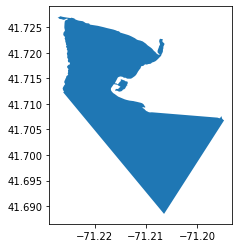

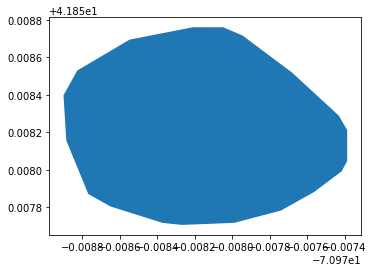

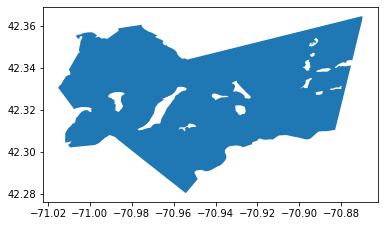

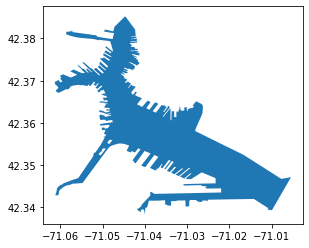

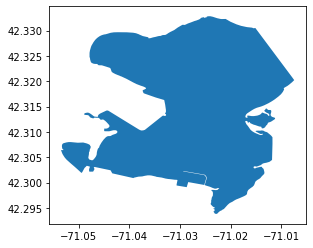

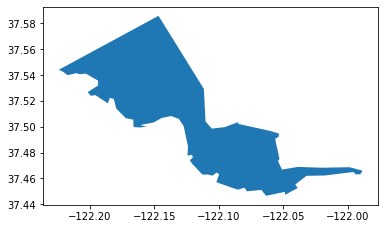

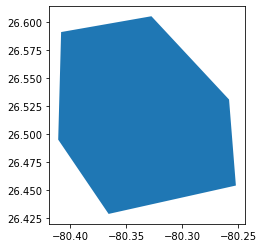

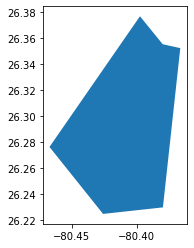

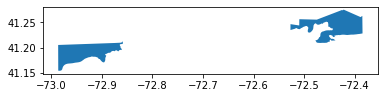

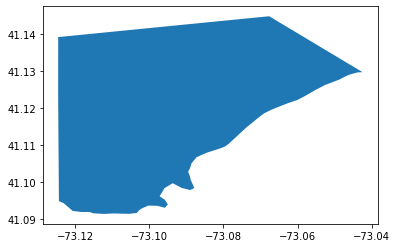

In [56]:
for i in range(10,20):
    uswb[i:i+1].plot()